In [ ]:
"""
Purpose: To Redo the width and trheshold jump changes
to a cleaner version that can have different
thresholds for axon and dendrite
"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-05-26 19:04:10,845 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 19:04:10,849 - settings - Setting database.user to celiib
INFO - 2021-05-26 19:04:10,851 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 19:04:10,870 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-05-26 19:04:10,872 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 19:04:10,890 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-05-26 19:04:11,429 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 19:04:11,434 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 19:04:11,436 - settings - Setting database.user to celiib
INFO - 2021-05-26 19:04:11,437 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 19:04:11,438 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 19:04:11,439 - settings - Setting database.user to celiib
INFO - 2021-05-26 19:04:11,439 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 19:04:11,441 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 19:04:11,991 - settings - Setting enable_python_native_blobs to True


In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-05-26 19:04:12,175 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 19:04:12,178 - settings - Setting database.user to celiib
INFO - 2021-05-26 19:04:12,180 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 19:04:12,184 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 19:04:12,819 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru

# Downloading the Neuron

In [5]:
segment_id = 864691135462735678
split_index = 0

decomp_path = (minnie.DecompositionAxon() & dict(segment_id=segment_id,
                                  split_index = split_index,
                                 )).fetch1("decomposition")
pre_filt_neuron = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [6]:
nviz.visualize_neuron(pre_filt_neuron,
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Checking that the branch boundary transition skeleton extends past upstream node if need be

In [8]:
[k for k in dir(nru) if "endpoint" in k]

['classify_endpoint_error_branches_from_limb_concept_network',
 'closest_branch_endpoint_to_limb_starting_coordinate',
 'ordered_endpoints_on_branch_path',
 'shared_skeleton_endpoints_for_connected_branches']

In [9]:
neuron_obj = pre_filt_neuron

In [14]:
import neuron_searching as ns
result_limb_branch = ns.query_neuron(neuron_obj,
    functions_list=["parent_angle","upstream_skeletal_length","skeletal_length","axon_width"],
    query="(parent_angle>110) and (skeletal_length>5000) and (upstream_skeletal_length>1000) and (axon_width>105)",
        function_kwargs=dict(comparison_distance=1000),
    return_dataframe=False,
    limbs_to_process=[neuron_obj.axon_limb_name])

print(f"result_limb_branch = {result_limb_branch}")
nviz.plot_limb_branch_dict(neuron_obj,
                           result_limb_branch)

result_limb_branch = {'L0': array([293, 318])}

 Working on visualization type: mesh


In [19]:
interesting_node = 318

In [17]:
limb_obj = pre_filt_neuron[0]
nru.upstream_node(limb_obj,interesting_node)

359

In [20]:
nru.shared_skeleton_endpoints_for_connected_branches?

In [22]:
common_endpoint = nru.shared_skeleton_endpoints_for_connected_branches(limb_obj,
                                                    318,
                                                    359)

In [23]:
up_width,d_width,up_sk,d_sk = nru.branch_boundary_transition(limb_obj,
                              edge=[359,318],
                            upstream_common_endpoint=common_endpoint,
                            downstream_common_endpoint=common_endpoint,
                            error_on_no_network_connection=False,
                            comparison_distance=10000,
                            offset=0,
                            width_name="no_spine_median_mesh_center",
                            verbose=False)

# Develop the Function that will find a path back to the starting coordinate

In [100]:
for k in limb_obj.get_branch_names():
    nru.branch_path_to_start_node(limb_obj = neuron_obj[0],
    branch_idx = k,
    include_branch_idx = False,
    skeletal_length_min = 2000,
    verbose = False)

In [52]:
import error_detection as ed
ed.width_jump_from_upstream_min(limb_obj=neuron_obj[0],
branch_idx=318,
skeletal_length_min = 2000,
verbose = False)



-22.86456963566667

# Trying out the function as a query

In [63]:
import neuron_searching as ns
width_jump_limb_branch = ns.query_neuron(neuron_obj,
                functions_list=["width_jump_from_upstream_min"],
                query="width_jump_from_upstream_min>50",
                function_kwargs=dict(skeletal_length_min=4000),
                return_dataframe=False,
        limbs_to_process=["L0"])

In [64]:
nviz.plot_limb_branch_dict(neuron_obj,
                          width_jump_limb_branch)


 Working on visualization type: mesh


# A) Putting Together the Width Query

In [122]:
nru.width(neuron_obj[1][0])

66.6561904816918

In [125]:
nru.width(neuron_obj[1][8]),nru.width(neuron_obj[1][2])

(469.26387991716604, 464.60513113947815)

limb_name = L1

 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L1 because was the limb in the first key


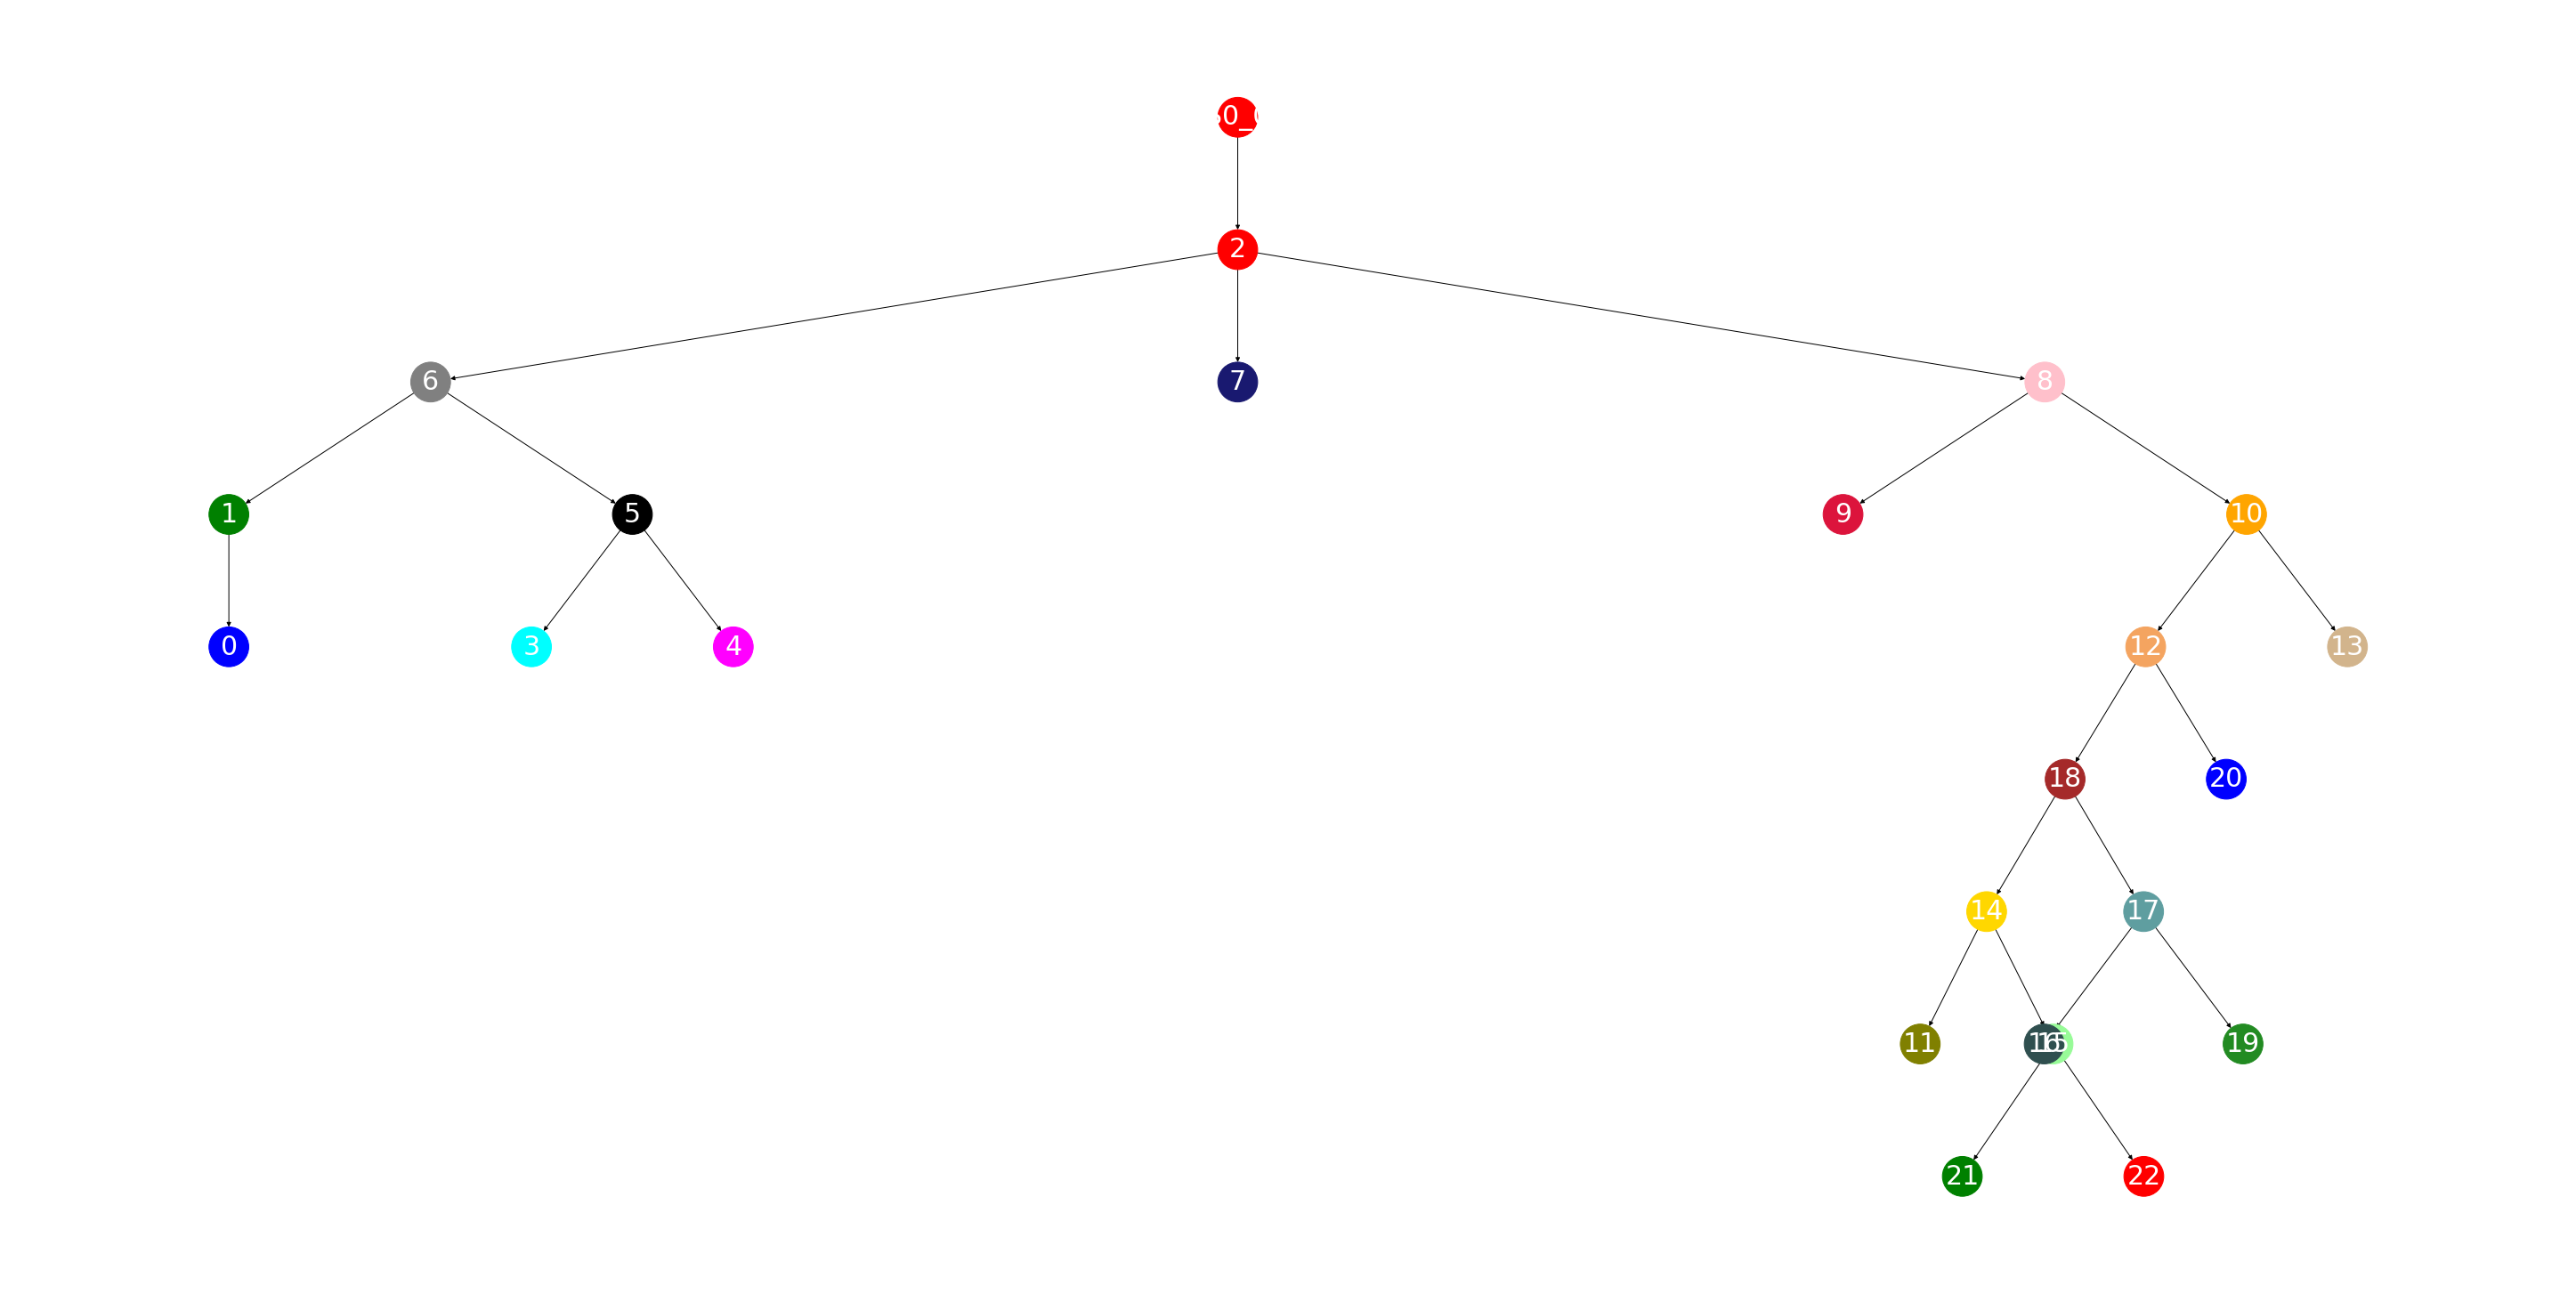

In [124]:
nviz.visualize_neuron_specific_limb(neuron_obj,
                                   1)

In [126]:
ed.width_jump_up_dendrite(neuron_obj,
                     plot_width_errors=True,
                         width_jump_max=3)

dendrite_limb_branch = {'L1': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), 'L2': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), 'L3': array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 'L4': array([0]), 'L5': array([0]), 'L6': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])}
width_errors = {'L1': array([ 0,  8, 21, 22]), 'L2': array([5])}

 Working on visualization type: mesh


{'L1': array([ 0,  8, 21, 22]), 'L2': array([5])}

In [116]:
ed.width_jump_up_axon(neuron_obj,
                     plot_width_errors=True)

width_errors = {'L0': array([  6, 293])}

 Working on visualization type: mesh


{'L0': array([  6, 293])}

In [141]:
neuron_obj.segment_id

864691135462735678

In [ ]:
upstream_skeletal_length_min = 5000
branch_skeletal_length_min = 6000
upstream_skeletal_length_min_for_min = 4000
width_jump_max = 200

dendrite_limb_branch = ns.query_neuron_by_labels(neuron_obj,
                                                        not_matching_labels=["axon"])

ed.width_jump_up_error_limb_branch_dict(neuron_obj,
                                     limb_branch_dict_restriction = dendrite_limb_branch,
                                     upstream_skeletal_length_min = upstream_skeletal_length_min,
                                     branch_skeletal_length_min = branch_skeletal_length_min,
                                     upstream_skeletal_length_min_for_min= upstream_skeletal_length_min_for_min,
                                    width_jump_max = width_jump_max,
                                    plot_final_width_jump = True,
                                       plot_upstream_skeletal_length_min=True)


# Develop the Width Query for the Dendrite and Axon (TO DO)

# For New Double Back Error

In [131]:
"""
Purpose: 
To identify the branches that double 
back in terms of skeleton

Pseudocode: 
1) Get the dendrite or axons (and maybe subset of axons with a certain width) limb branch
2) Only get the branches that have certain upstream and are of certain length
- will have different parameters for different axon/dendrite
3) Query for those branches that double back with the specific parameters
4) Plot final query

"""

ed.double_back_error_limb_branch_dict(neuron_obj,
                                      double_back_threshold=140,
                                  limb_branch_dict_restriction=axon_limb_branch,
                                  plot_final_double_back=True,
                                     comparison_distance = 1000,
                                       offset = 500)

double_back_limb_branch_dict (WITH threshold 140) = {'L0': array([ 35,  40,  49,  93,  98, 120, 125, 161, 175, 183, 195, 207, 228,
       232, 244, 314, 318, 338, 346])}

 Working on visualization type: mesh


{'L0': array([ 35,  40,  49,  93,  98, 120, 125, 161, 175, 183, 195, 207, 228,
        232, 244, 314, 318, 338, 346])}

In [134]:
ed.double_back_dendrite(neuron_obj,
                        double_back_threshold=90,
                         comparison_distance = 3000,
                         offset = 0,
                         branch_skeletal_length_min = 4000, #deciding which branches will be skipped because of length
                        plot_starting_limb_branch = True,
                         plot_double_back_errors = True
                        )

current_limb_branch_dict = {'L1': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), 'L2': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), 'L3': array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 'L4': array([0]), 'L5': array([0]), 'L6': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])}

 Working on visualization type: mesh


double_back_errors = {'L1': array([ 1, 15, 17, 18, 21])}

 Working on visualization type: mesh


{'L1': array([ 1, 15, 17, 18, 21])}

In [137]:
ed.double_back_axon_thin(neuron_obj,
                          axon_width_threshold = 100,
                        double_back_threshold=140,
                         comparison_distance = 1200,
                         offset = 0,
                         branch_skeletal_length_min = 4000, #deciding which branches will be skipped because of length
                         plot_starting_limb_branch = True,
                         plot_double_back_errors = True,
                        )

current_limb_branch_dict = {'L0': array([  1,   2,   4,   5,   7,   8,   9,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  23,  24,  25,  26,  28,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  45,  46,  47,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  82,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  98, 100, 101, 102, 103, 105, 106,
       107, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151,
       152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 170, 171, 172, 174, 175, 176, 177, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 199, 200

double_back_errors = {'L0': array([ 40,  49,  65,  69,  90,  98, 113, 161, 183, 195, 228, 244, 314,
       327, 346])}

 Working on visualization type: mesh


{'L0': array([ 40,  49,  65,  69,  90,  98, 113, 161, 183, 195, 228, 244, 314,
        327, 346])}

In [140]:
import axon_utils as au
ed.double_back_axon_thick(neuron_obj,
                          axon_width_threshold = au.axon_thick_threshold,
                        double_back_threshold=120,
                         comparison_distance = 1000,
                         offset = 0,
                         branch_skeletal_length_min = 4000, #deciding which branches will be skipped because of length
                         plot_starting_limb_branch = True,
                         plot_double_back_errors = True,
                        )

current_limb_branch_dict = {'L0': array([  0,   3,   6,  10,  22,  27,  29,  43,  44,  48,  68,  81,  83,
        97,  99, 104, 110, 115, 122, 137, 147, 148, 156, 169, 173, 178,
       198, 202, 210, 211, 230, 234, 239, 243, 246, 250, 258, 259, 260,
       266, 274, 276, 277, 279, 282, 287, 293, 295, 297, 298, 300, 304,
       308, 317, 318, 320, 328, 330, 332, 336, 340, 341, 342, 344, 348,
       349, 350, 352, 355, 356, 357, 358, 359, 360, 362, 366, 368, 370,
       375, 379, 380, 386, 387])}

 Working on visualization type: mesh


double_back_errors = {'L0': array([318])}

 Working on visualization type: mesh


{'L0': array([318])}